# Network Science. Project #1
## Evgeniya Shevchuk

### Part 1. Loading and preprocessing data. Network description.

In [1]:
import vk_api
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import collections
import requests
from transliterate import translit

In [2]:
def get_friends_ids(user_id, user_token = -1):
    if user_token == -1:
        access_token = '2199ecf7326108563a5f4b13bd0f3b3c8a46c1df3f4c5652657168f2ae2be15223b67c5bd66fa1c62cf22'
    friends_url = f'https://api.vk.com/method/friends.get?user_ids={user_id}&fields=country,sex&access_token={access_token}&v=5.103' 
    json_response = requests.get(friends_url.format(user_id)).json()
    if json_response.get('error'):
        return list()
    return json_response['response']['items']

In [3]:
def get_mutual_friends_ids(user_id, friend_id, user_token = -1): 
    if user_token == -1:    
        access_token = '2199ecf7326108563a5f4b13bd0f3b3c8a46c1df3f4c5652657168f2ae2be15223b67c5bd66fa1c62cf22'
        
    friends_url = f'https://api.vk.com/method/friends.getMutual?source_uid={user_id}&target_uid={friend_id}&fields=bdate&access_token={access_token}&v=5.103' 
    json_response = requests.get(friends_url.format(user_id, friend_id)).json()
    if json_response.get('error'):
        return list()
    return json_response['response']

In [4]:
graph = {}
my_id = 31162482
friends = get_friends_ids(my_id)
# print (friends)
for friend in friends:
    friend_id = friend['id']
    friend_name = friend['first_name'] + ' ' + friend['last_name']
    name = translit(friend_name, 'ru', reversed = True)
    name = str(translit(name, 'uk', reversed = True)) #because there are some names originally written in Ukrainian
    try:
        friend_sex = friend['sex']
    except:
        friend['sex'] = ''
    try:
        friend_c = translit(friend['country']['title'],'ru', reversed = True)
    except:
        friend['country'] = ''
    time.sleep(1) 
    mutual_friends = get_mutual_friends_ids(my_id, friend_id)
    mutual_friends.append(friend_id)
    if len(mutual_friends) > 1: # because if < 1 then the user is usually blocked or deleted
        graph[friend_id] = (mutual_friends, name, friend_sex, friend_c)
        print('Processing id: ', friend_id, name, len(graph[friend_id][0]))

Processing id:  2056757 Marija Smoleva 3
Processing id:  2251068 Idelija Ajzjatulova 4
Processing id:  5903061 Ara Chan 15
Processing id:  6405964 Andrij Stavits'kij 31
Processing id:  7507146 Alena Nekrylova 2
Processing id:  7584948 Natalija Volik 15
Processing id:  8368517 Aleksandr Vetchinov 4
Processing id:  9381730 Aleshka Maksimuk 3
Processing id:  9584785 Viktor Shpirko 20
Processing id:  10842197 Aleksandra Balova 8
Processing id:  11388366 Anna Kievskaja 12
Processing id:  13076004 Anna Hromjak 27
Processing id:  13750810 Anja Safronova 3
Processing id:  13916264 Andrij Martinenko 14
Processing id:  15597975 Sasha Shelestov 6
Processing id:  15906873 Anna Petrosova 2
Processing id:  19611477 Alena Kamkova 10
Processing id:  21256206 Nazar Omel'janovich 35
Processing id:  21750591 Julja Kulinich 25
Processing id:  22599222 Evgenij Mustafaev 4
Processing id:  23269733 Gajane Tevon'jan 2
Processing id:  23278470 Nadezhda Smirnova 3
Processing id:  27209519 Alina Skidanova 14
Pro

In [5]:
G = nx.Graph(directed = False)
for i in graph:
    G.add_node(i, name=graph[i][1], sex=graph[i][2], country=graph[i][3])
    for j in graph[i][0]:
        if j in graph:
            G.add_edge(i, j)

In [6]:
nx.write_gml(G, "test.gml")

Some description of the graph

In [7]:
print("Nodes:", len(G.nodes)) #after some modifications
print("Edges:", len(G.edges))

Nodes: 151
Edges: 1161


C:\Users\user\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


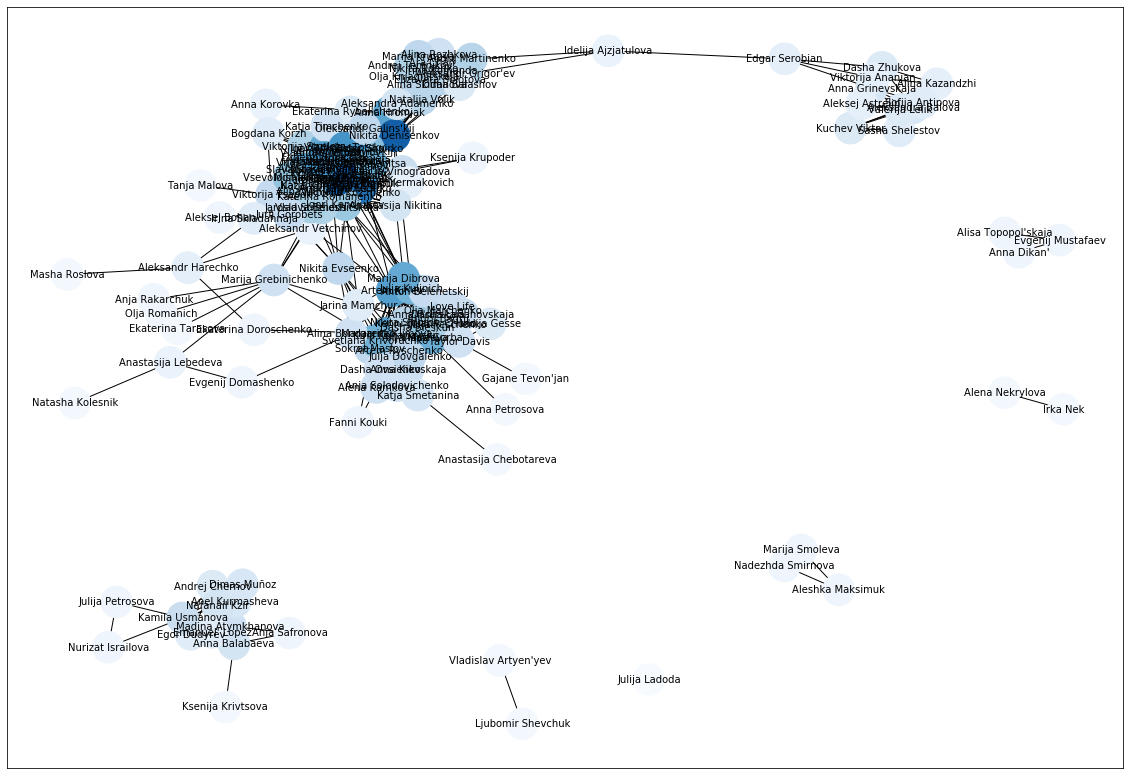

In [8]:
k = dict(nx.degree(G))
d = {item:G.nodes[item]['name'] for item in G.nodes}
plt.figure(1, figsize=(20,14))
coord = nx.spring_layout(G,k=0.15,iterations=50)
nx.draw_networkx(G,
                 pos=coord,
                 nodelist=list(k.keys()),
                 node_size = 1000,
                 node_color=list(k.values()),
                 labels=d,
                 font_size = 10,
                 cmap=plt.cm.Blues)

Not very _gorgeous_ but still quite pretty graph you may find on the slides.

DEGREE DISTRIBUTION

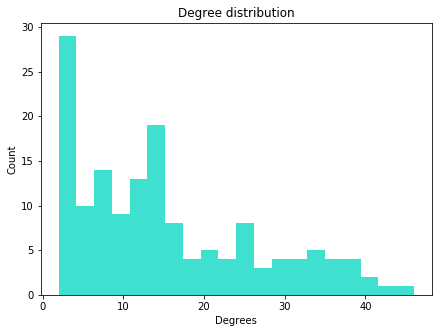

In [9]:
plt.figure(1, figsize=(7, 5))
plt.xlabel("Degrees")
plt.ylabel("Count")
plt.title("Degree distribution")
out = plt.hist(list(k.values()), bins=20, color ='turquoise')

DIAMETER

In [10]:
Gc = max(nx.connected_component_subgraphs(G), key=len)
nx.diameter(Gc)

10

CLUSTERING COEFFICIENT

In [11]:
clust_coeff = nx.transitivity(G)
print (clust_coeff)

0.6617708381596626


### Part 2. Structural Analysis.

DEGREE CENTRALITY

Oleksandr Rjabov 0.3066666666666667
Andrij Timovs'kij 0.2866666666666667
Diana Stepanjuk 0.2733333333333334
Taras Mihal'chuk 0.26666666666666666
Bogdan Koval' 0.26


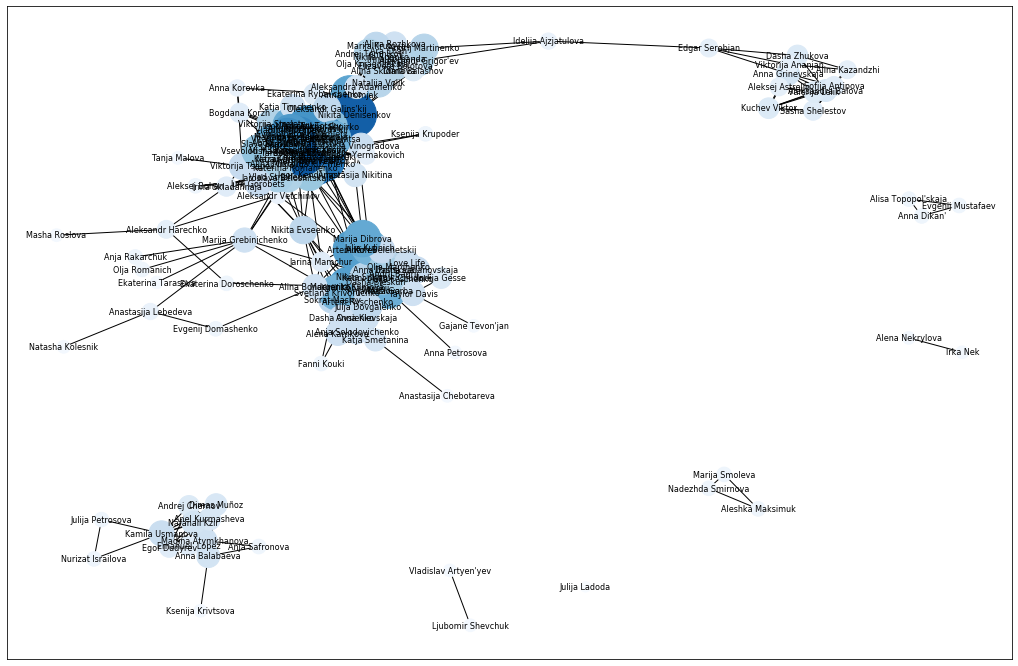

In [12]:
dc = nx.degree_centrality(G)
sorted_dc = {k: v for k, v in sorted(dc.items(), key=lambda item: item[1], reverse=True)}
for i, (ind, value) in enumerate(sorted_dc.items()):
    if i >4:
        break
    print(G.nodes[ind]['name'], value)
plt.figure(1, figsize=(18,12))
nx.draw_networkx(G,
          coord,
#           with_labels = False,
          nodelist=dc.keys(),
          node_size = [d*8000 for d in dc.values()],
          node_color=list(dc.values()),
          labels=d,
          font_size=8,
          cmap=plt.cm.Blues,
          )

Those are friends who have the most mutual friends with me.

CLOSENESS CENTRALITY

Nikita Denisenkov 0.3891176470588235
Andrij Timovs'kij 0.378
Diana Stepanjuk 0.37006993006993005
Oleksandr Rjabov 0.36878048780487804
Igor Kostik 0.36622837370242217


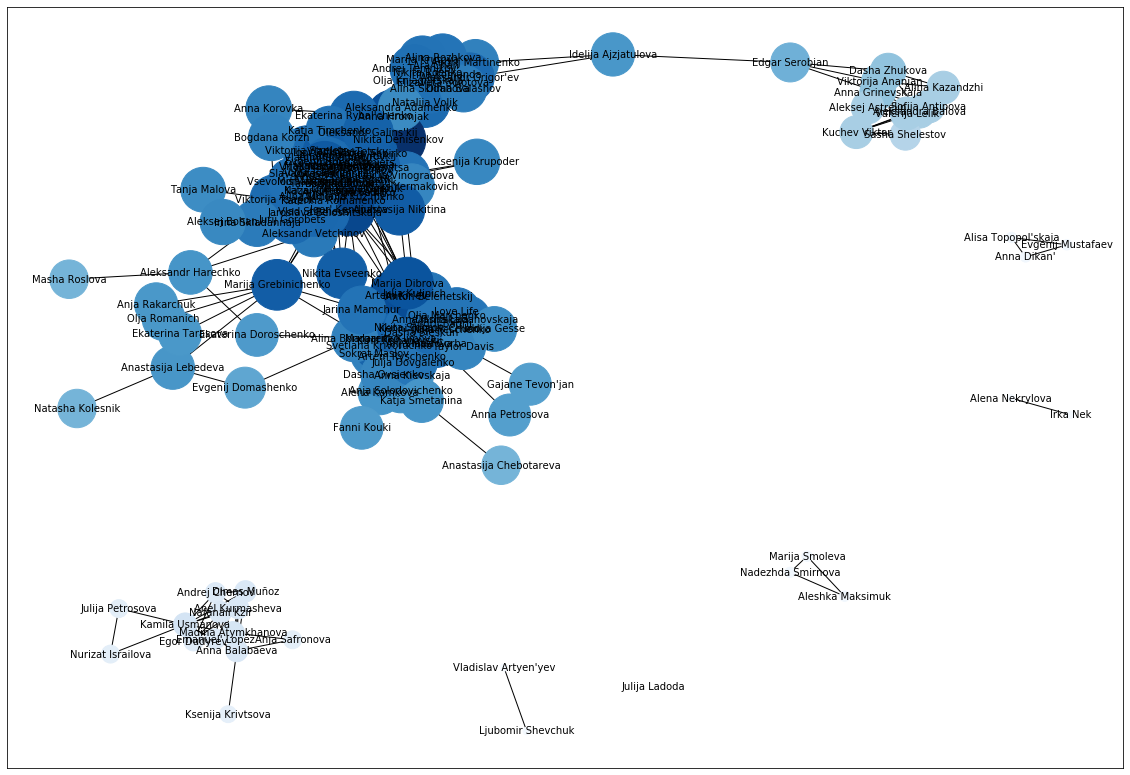

In [13]:
cc = nx.closeness_centrality(G)
sorted_cc = {k: v for k, v in sorted(cc.items(), key=lambda item: item[1], reverse=True)}
for i, (ind, value) in enumerate(sorted_cc.items()):
    if i >4:
        break
    print(G.nodes[ind]['name'], value)
plt.figure(1, figsize=(20,14))
nx.draw_networkx(G,
          coord,
          nodelist=cc.keys(),
          node_size = [c*8000 for c in cc.values()],
          node_color=list(cc.values()),
          labels=d,
          font_size=10,
          cmap=plt.cm.Blues,
          )

Those are friends who have diverse contacts so they have the closest relations to each section of friends.

BETWEENNESS CENTRALITY

Nikita Denisenkov 0.16108522392496663
Idelija Ajzjatulova 0.11319910514541388
Edgar Serobjan 0.10380313199105146
Aleksandr Grigor'ev 0.0983306091982835
Julja Kulinich 0.07946273091140028


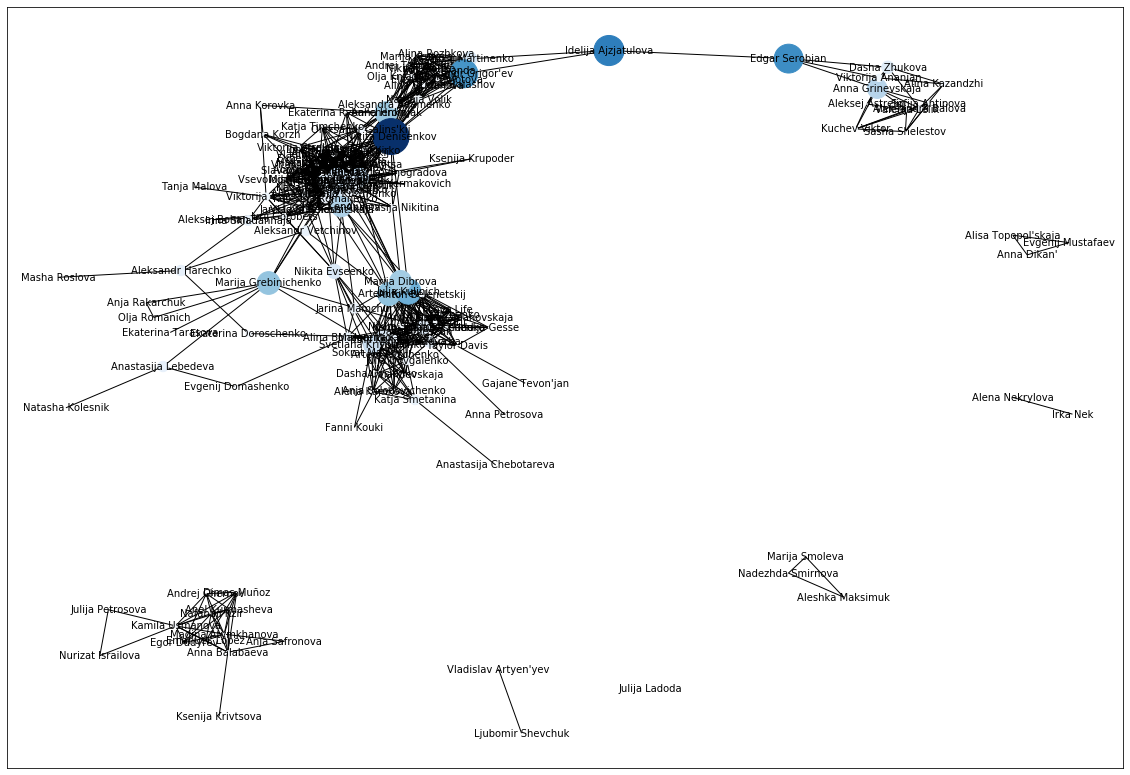

In [14]:
bc = nx.betweenness_centrality(G)
sorted_bc = {k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}
for i, (ind, value) in enumerate(sorted_bc.items()):
    if i >4:
        break
    print(G.nodes[ind]['name'], value)
plt.figure(1, figsize=(20,14))
nx.draw_networkx(G,
          coord,
          nodelist=bc.keys(),
          node_size = [b*8000 for b in bc.values()],
          node_color=list(bc.values()),
          labels=d,
          font_size=10,
          cmap=plt.cm.Blues,
          )

Those are friends who connect different communities with each other.

PAGE-RANK

Oleksandr Rjabov 0.013302822793866501
Nikita Denisenkov 0.012534495204171013
Margarita Klimova 0.012247951751210259
Andrij Timovs'kij 0.011874764090542476
Diana Stepanjuk 0.011474436817665492


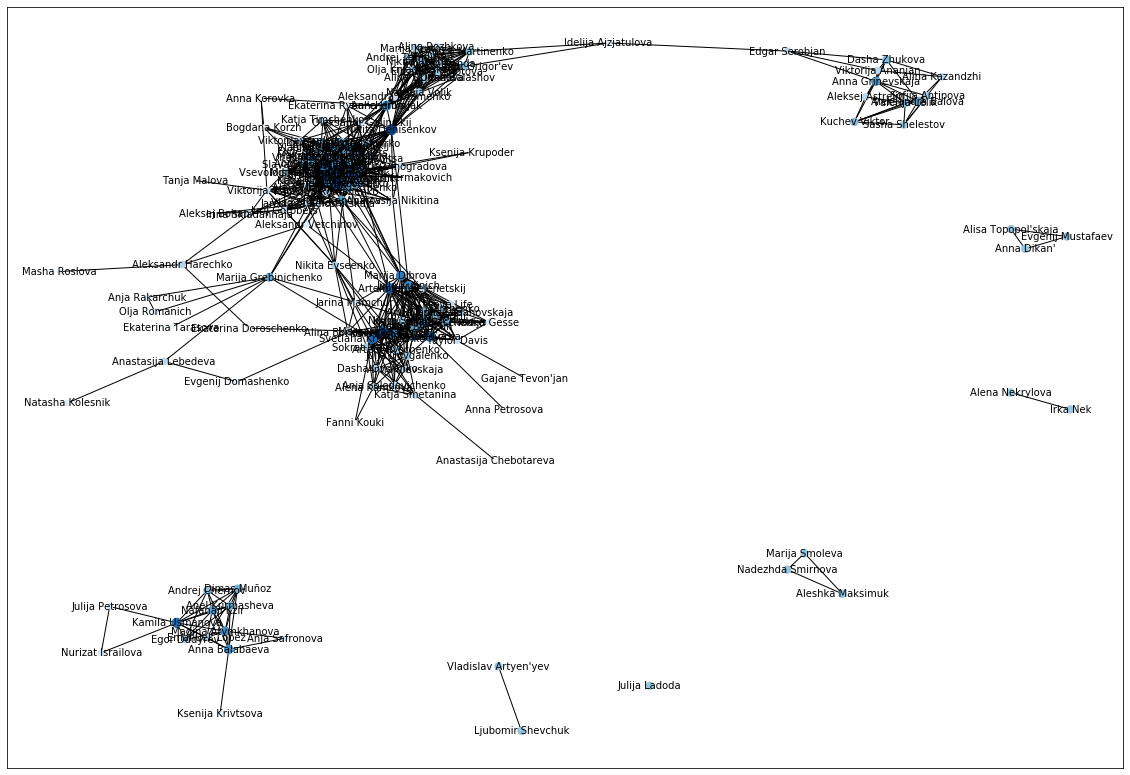

In [15]:
pr = nx.pagerank(G)
sorted_pr = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}
for i, (ind, value) in enumerate(sorted_pr.items()):
    if i >4:
        break
    print(G.nodes[ind]['name'], value)
plt.figure(1, figsize=(20,14))
nx.draw_networkx(G,
          coord,
          nodelist=pr.keys(),
          node_size = [p*8000 for p in pr.values()],
          node_color=list(pr.values()),
          labels=d,
          font_size=10,
          cmap=plt.cm.Blues,
          )

We may notice that the result is somehow mean between all three cenralities but if we compare to each other the closest "distribution" is closeness centrality.

ASSORTATIVE MIXING

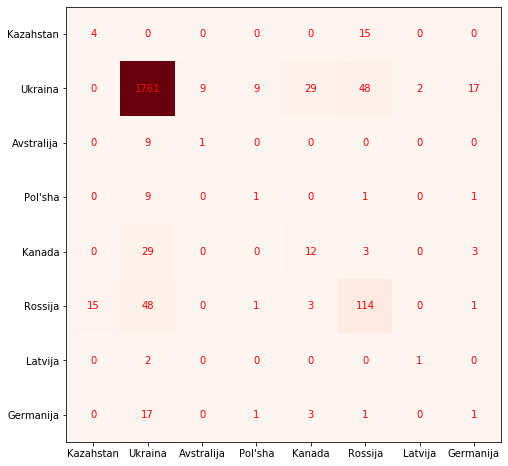

In [16]:
mixing_c = nx.attribute_mixing_matrix(G,'country', normalized = False)
countries = set([G.nodes[item]['country'] for item in G.nodes])
f, ax = plt.subplots(figsize=(8,8))
ax.set_xticks(np.arange(len(countries)))
ax.set_yticks(np.arange(len(countries)))
ax.set_xticklabels(countries)
ax.set_yticklabels(countries)
for i in range(len(countries)):
    for j in range(len(countries)):
         text = ax.text(i, j, int(mixing_c[i, j]), ha="center", va="center", color="r")
im = plt.imshow(mixing_c, cmap = 'Reds')

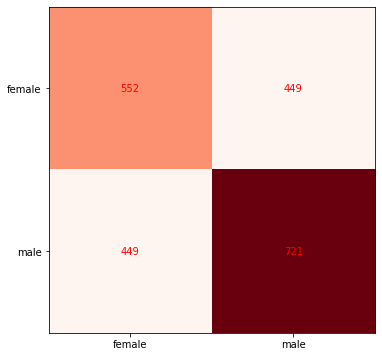

In [17]:
mixing_sex = nx.attribute_mixing_matrix(G,'sex',normalized = False)
sex = ['female','male']
f, ax = plt.subplots(figsize=(6,6))
ax.set_xticks(np.arange(len(sex)))
ax.set_yticks(np.arange(len(sex)))
ax.set_xticklabels(sex)
ax.set_yticklabels(sex)
for i in range(2):
    for j in range(2):
         text = ax.text(i, j, int(mixing_sex[i, j]), ha="center", va="center", color="r")
im = plt.imshow(mixing_sex, cmap = 'Reds')

1.As for countries, it is obvious that friends from Ukraine have most of the connections with Ukrainians as well. People from Russia tend to have friends from Russia.

2.Because mostly I have friends from Ukraine they have a lot more connections outside the country comparing to others.

3.Boys rather prefer to be friends with boys while for girls these numbers are similar.

NODE SIMILARITY

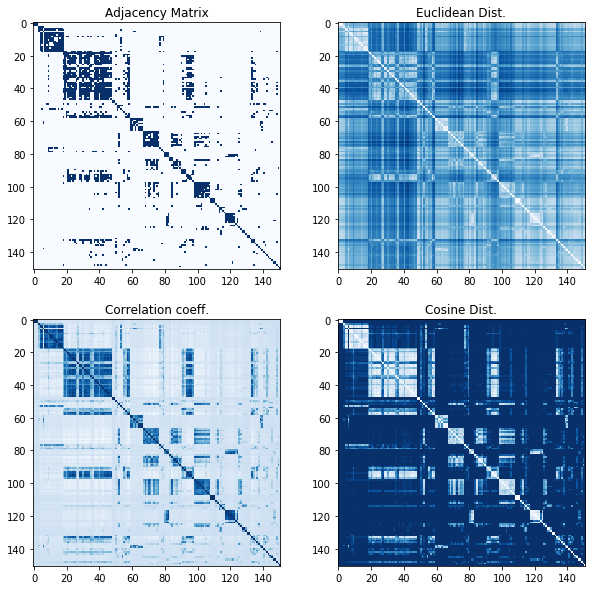

In [18]:
import scipy.spatial as spt


A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Blues', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    
plotDist(A)   
    

RANDOM GRAPH MODELS

Original
Average quantity of degrees: 17.212598425196852
Clustering coeff: 0.6610955056179775
Average shortest path: 3.194100737407824
Erdos
Average quantity of degrees: 83.79527559055119
Clustering coeff: 0.6655538941766914
Average shortest path: 1.3349581302337208
Powerlaw
Average quantity of degrees: 7.653543307086614
Clustering coeff: 0.19885057471264367
Average shortest path: 2.5608048993875765
Watts
Average quantity of degrees: 4.0
Clustering coeff: 0.03788748564867968
Average shortest path: 3.6931633545806775


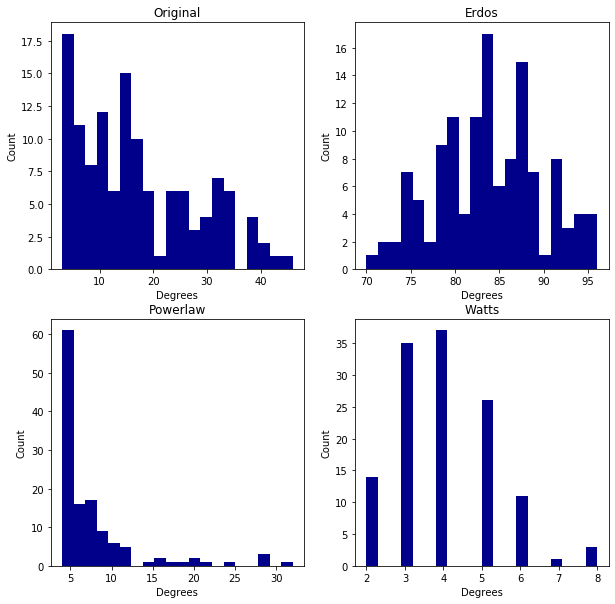

In [19]:
nodes = len(Gc.nodes) #Gc - largest connected component, was created at the beginning, 
edges = len(Gc.edges)
clust_coeff_lcc = nx.transitivity(Gc)
graphs = {}
graphs['Original'] = Gc
graphs['Erdos'] = nx.erdos_renyi_graph(nodes, clust_coeff_lcc)
graphs['Powerlaw'] = nx.powerlaw_cluster_graph(nodes, 4, clust_coeff_lcc)
graphs['Watts'] = nx.watts_strogatz_graph(nodes, 4, clust_coeff_lcc)

# print(graphs)

for i, (name, graph) in enumerate(graphs.items()):
    print (name)
    degrees = [item[1] for item in nx.degree(graph)]
    print('Average quantity of degrees:', np.mean(degrees))
    print('Clustering coeff:', nx.transitivity(graph))
    print('Average shortest path:', nx.average_shortest_path_length(graph))

plt.figure(1, figsize=(10, 10))
for i, (name, graph) in enumerate(graphs.items()):
    degrees = [item[1] for item in nx.degree(graph)]
    plt.subplot(2,2,i+1)
    plt.xlabel("Degrees")
    plt.ylabel("Count")
    plt.title(name)
    plt.hist(degrees, bins=20, color ='darkblue')

Closest to the original distribution is powerlaw model despite it's not very accurate as well.

### Part 3. Community detection

CLIQUE

10


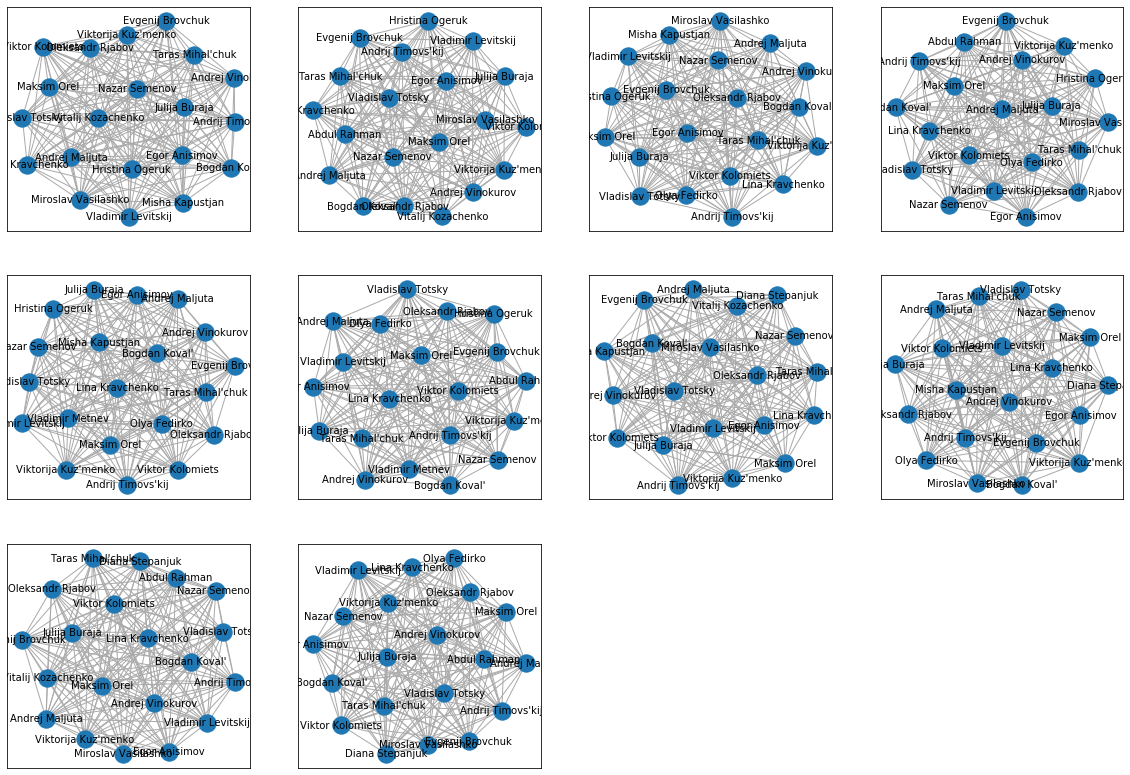

In [20]:
from networkx.algorithms import clique
cliques = list(clique.find_cliques(G))
max_cliques = []
for i in cliques:
    if len(i) >= 20:
        max_cliques.append(i)
print(len(max_cliques))

plt.figure(1, figsize=(20, 14))
for i, clique in enumerate(max_cliques):
    plt.subplot(3, 4, i+1)
    G_subgraph = nx.subgraph(G, clique)
    coord = nx.spring_layout(G_subgraph)
    d = {item:G.nodes[item]['name'] for item in G_subgraph.nodes}
    nx.draw_networkx(G_subgraph,
                 pos = coord,
                 nodelist=list(clique),
                 labels=d,
                 edge_color='#AAAAAA',
                 font_size=10)


All of the presented cliques form univerity group with some modifications as far as there are people who are not friends.